# N03. Análisis del Precio de Bolsa promedio Mensual (Pbm)
Los precios de la energía en bolsa son horarios y se expresan en Pesos por kWh.
La fuente de esta información es XM. A partir de los Precios de Bolsa Horario (Pbh) se realizará el análisis de los valores históricos de los Precios de Bolsa promedio Mensual (Pbm).

Ya se cuenta con varios archivos en formato 'parquet': PbhL, Pbm, Pba y PbhEsca.

## 3.1. Carga paquetes

In [1]:
#*******************************************************************************       
# 3.1.1. Carga paquetes Python requeridos.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget
pd.options.plotting.backend = "plotly"

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import seaborn as sns

## 3.2. Lee pbhL

In [46]:
# pbhL = pd.read_parquet('parquet/pbhL.parquet.gzip', engine='pyarrow')
# pbhL.to_parquet('parquet/pbhL.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
pbhL = pd.read_parquet('parquet/pbhL.parquet.gzip', engine='fastparquet')

## 3.3. Grafica pbhL

In [3]:
sns.set_theme()

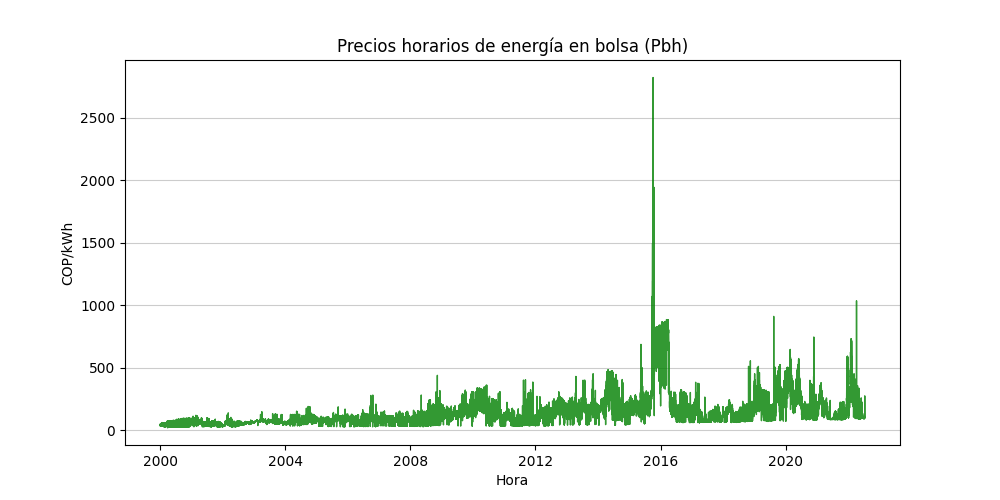

In [47]:
#*******************************************************************************
# 3.3.1. Grafica de pbhL.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Precios horarios de energía en bolsa (Pbh)')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Hora')
ax1.plot(pbhL.index, pbhL.precio, 'g-', label='Pbh', linewidth=1, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
#plt.ylim(0, 500)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

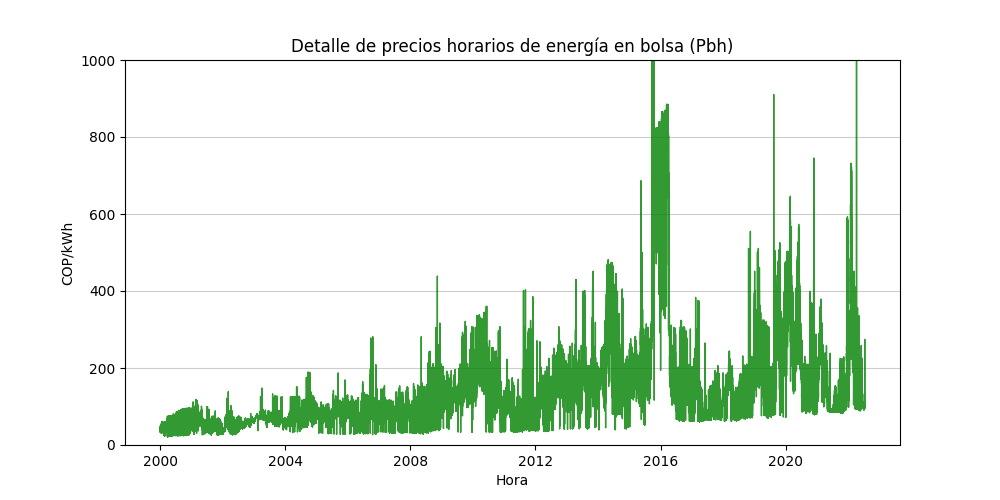

In [50]:
#*******************************************************************************
# 3.3.2. Grafica de detalle de pbhL.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Detalle de precios horarios de energía en bolsa (Pbh)')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Hora')
ax1.plot(pbhL.index, pbhL.precio, 'g-', label='Pbh', linewidth=1, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 1000)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

El valor mínimo del precio de bolsa horario aumenta de manera continua. Este valor se conoce como el Costo Equivalente Real de Energía (CERE). Sin embargo, este valor solo se puede calcular al final del mes. Por eso, XM publica al principio del mes un estimado de este valor que se denomina Costo Equivalente de Energía (CEE). Este valor CEE se tiene en cuenta por los participantes en el mercado mayorista para ofertar sus precios de bolsa horarios.   

## 3.4. Valor de CEE
El valor CEE calculado a principio de mes y el valor CERE calculado a final del mes, representan el aporte que hacen los agentes del mercado por cada kilovatio - hora consumido, para remunerar a los agentes que tienen disponibles plantas de generación que respaldan el sistema y a las que les fue asignado un cargo de confiabilidad mediante las diferentes subastas realizadas por la UPME.

In [16]:
#*******************************************************************************       
# 3.4.1. Crea la máquina para conectarse a la base de datos dbXm.db.
#*******************************************************************************
engine = create_engine('sqlite:///dbXm.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()
#*******************************************************************************       
# 3.4.2. Lee CEE y CERE desde la base de datos dbXm.db.
#*******************************************************************************
consulta = "SELECT * FROM CEE" #CEE.
cee = pd.read_sql(consulta, engine, parse_dates=["Date"])
consulta = "SELECT * FROM CERE" #CERE.
cere = pd.read_sql(consulta, engine, parse_dates=["Date"])

In [23]:
#*******************************************************************************       
# 3.4.3. Organiza CEE y CERE en cee_cere.
#*******************************************************************************
# cee = cee.drop(columns='CEEId', axis=1)
# cee = cee.set_index('Date')
# cere = cere.drop(columns='CEREId', axis=1)
# cere = cere.set_index('Date')
# cere.columns = ['cere']
# cee.index.name = 'mes'
# cee.columns = ['cee']
# cee_cere = cee.join(cere, how='inner')

In [27]:
#*******************************************************************************
# 3.4.4. Salva y lee cee_cere.
#*******************************************************************************
#Lee cee_cer
# cee_cere.to_parquet('parquet/cee_cere.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee cee_cer
cee_cere = pd.read_parquet('parquet/cee_cere.parquet.gzip', engine='fastparquet')

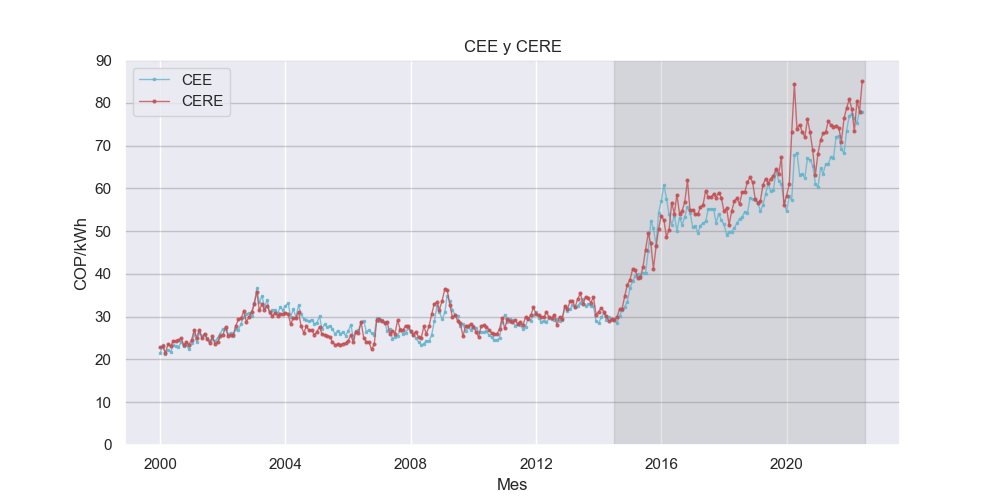

In [28]:
#*******************************************************************************
# 3.4.5. Grafica de cee y cere.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('CEE y CERE')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(cee_cere.index, cee_cere.cee, 'cs-', label='CEE', linewidth=1, \
    alpha=0.8, markersize=2)
ax1.plot(cee_cere.index, cee_cere.cere, 'ro-', label='CERE', linewidth=1, \
    alpha=0.8, markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2014-07-01'), pd.to_datetime('2022-07-01'), \
     color='#808080', alpha=0.2)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-07-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 90)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

In [39]:
#*******************************************************************************
# 3.4.6. Crea cee_cere2014_07 y la regresión.
#*******************************************************************************
# cee_cere2014_07 = \
#     cee_cere[pd.to_datetime('2014-07-01'):pd.to_datetime('2022-06-01')]
# cee_cere2014_07.insert(loc=2, column='var_x', \
#     value=range(0, 96), allow_duplicates=False)
# a, b = np.polyfit(cee_cere2014_07.var_x, cee_cere2014_07.cee, 1)
# cee_cere2014_07.insert(loc=3, column='var_y', \
#     value=cee_cere2014_07['var_x']*a + b, allow_duplicates=True)
# a = 0.36259163727618265
# b = 38.6090743127147
# a * X + b; donde 0 es 2014_07.

In [45]:
#*******************************************************************************
# 3.4.7. Salva y lee cee_cere2014_07.
#*******************************************************************************
#Salva el cee_cere2014_07.
# cee_cere2014_07.to_parquet('parquet/cee_cere2014_07.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee el DataFrame cee_cere2014_07.
# cee_cere2014_07 = pd.read_parquet('parquet/cee_cere2014_07.parquet.gzip', \
#     engine='fastparquet')

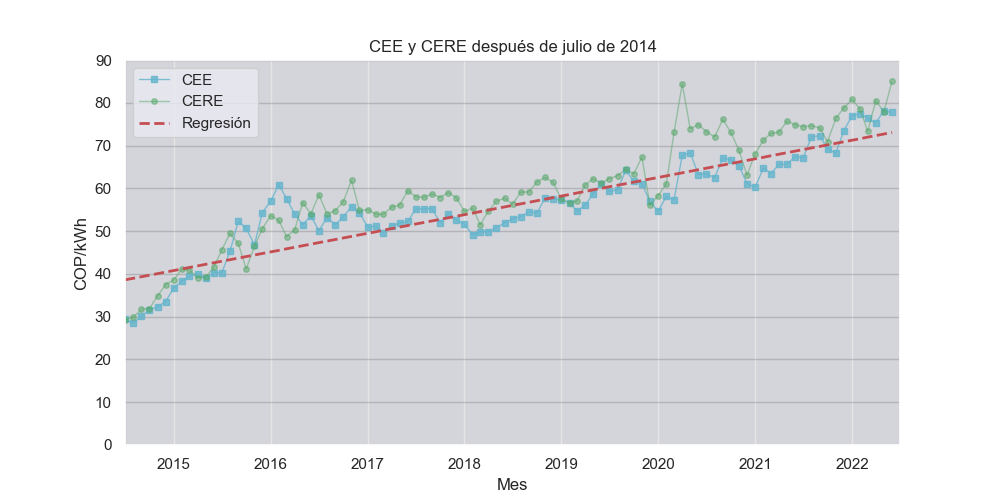

In [48]:
#*******************************************************************************
# 3.4.8. Grafica de cee y cere después de julio de 2014.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('CEE y CERE después de julio de 2014')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(cee_cere2014_07.index, cee_cere2014_07.cee, 'cs-', \
    label='CEE', linewidth=1, alpha=0.8, markersize=4)
ax1.plot(cee_cere2014_07.index, cee_cere2014_07.cere, 'go-', \
    label='CERE', linewidth=1, alpha=0.5, markersize=4)
ax1.plot(cee_cere2014_07.index, cee_cere2014_07['var_y'], 'r--', \
    label='Regresión', linewidth=2)
ax1.axvspan(pd.to_datetime('2014-07-01'), pd.to_datetime('2022-07-01'), \
     color='#808080', alpha=0.2)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2014-07-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 90)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

## 3.5. Valor del Precio de Escasez
El Precio de Escasez es el máximo valor del precio de energía en bolsa, que paga un consumidor de energía. Cuando el precio de bolsa alcanza el Precio de Escasez, los agentes a los que se les paga el Cargo de Confiabilidad entran a generar con sus plantas de respaldo. 

In [49]:
#*******************************************************************************       
# 3.5.1. Lee PreEsca desde la base de datos dbXm.db.
#*******************************************************************************
consulta = "SELECT * FROM PrecEsca" #Precio de Escasez.
precEsca = pd.read_sql(consulta, engine, parse_dates=["Date"])

In [54]:
#*******************************************************************************       
# 3.5.2. Organiza precEsca.
#*******************************************************************************
# precEsca = precEsca.drop(columns='PrecEscaId', axis=1)
# precEsca = precEsca.set_index('Date')
# precEsca.index.name = 'mes'
# precEsca.columns = ['precEsca']
# precEsca.insert(loc=1, column='anioMes', \
#     value=pd.to_datetime(precEsca.index).to_period('M'), \
#         allow_duplicates=True)
# precEsca = precEsca.groupby(['anioMes']).mean()
# precEsca.index = precEsca.index.to_timestamp()
# precEsca

In [56]:
#*******************************************************************************
# 3.5.3. Salva y lee precEsca.
#*******************************************************************************
#Salva el precEsca.
# precEsca.to_parquet('parquet/precEsca.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee el precEsca.
precEsca = pd.read_parquet('parquet/precEsca.parquet.gzip', \
    engine='fastparquet')

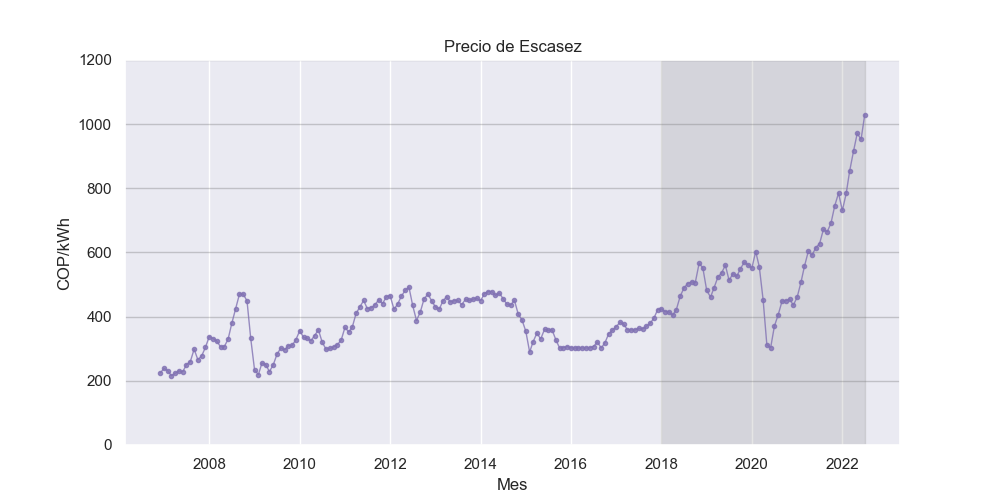

In [57]:
#*******************************************************************************
# 3.5.4. Grafica de Precio de Escasez.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, \
    hspace=None)
ax1.set_title ('Precio de Escasez')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(precEsca.index, precEsca.precEsca, 'mo-', label='Precio de Escasez', \
    linewidth=1, alpha=0.8, markersize=3)
# ax1.plot(cee_cere2014_07.index, cee_cere2014_07.cere, 'go-', label='CERE', \
#     linewidth=1, alpha=0.5, markersize=4)
# ax1.plot(cee_cere2014_07.index, cee_cere2014_07['var_y'], 'r--', \
#     label='Regresión', linewidth=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', \
# markersize=2)
ax1.axvspan(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'), \
     color='#808080', alpha=0.2)
# plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-07-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 1200)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

In [58]:
#*******************************************************************************
# 3.5.5. Grafica de Precio de Escasez desde 2018-01 y su regresión.
#*******************************************************************************
# precEsca2018_01 = precEsca[pd.to_datetime('2018-01-01'):pd.to_datetime('2022-06-01')]
# precEsca2018_01.insert(1, 'var_x', range(0, 54), allow_duplicates=False) 
# a, b = np.polyfit(precEsca2018_01.var_x, precEsca2018_01.precEsca, 1)
# precEsca2018_01.insert(2, 'var_y', precEsca2018_01.loc[:, 'var_x']*a + b, allow_duplicates=True) 
# precEsca2018_01
# b
# a = 6.422346949708909
# b = 386.3147330506155
# a * X + b; donde 0 es 2018_01.

In [60]:
#Guarda el DataFrame precEsca2018_01.
# precEsca2018_01.to_parquet('parquet/precEsca2018_01.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee el DataFrame precEsca2018_01.
precEsca2018_01 = pd.read_parquet('parquet/precEsca2018_01.parquet.gzip', \
    engine='fastparquet')

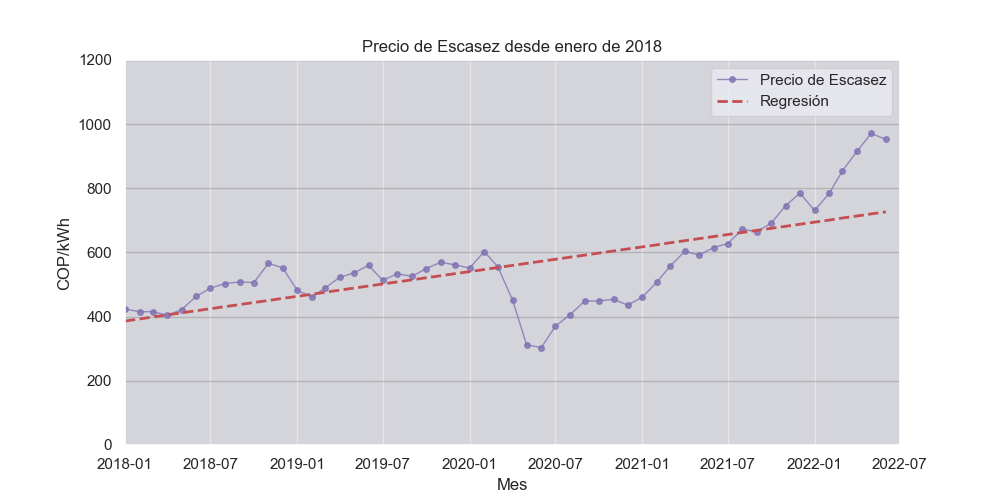

In [61]:
#*******************************************************************************
# 3.5.4. Grafica de Precio de Escasez después de enero de 2018.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, \
    hspace=None)
ax1.set_title ('Precio de Escasez desde enero de 2018')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(precEsca2018_01.index, precEsca2018_01.precEsca, 'mo-', \
    label='Precio de Escasez', \
    linewidth=1, alpha=0.8, markersize=4)
ax1.plot(precEsca2018_01.index, precEsca2018_01['var_y'], 'r--', \
    label='Regresión', linewidth=2)
# ax1.plot(cee_cere2014_07.index, cee_cere2014_07.cere, 'go-', label='CERE', \
#     linewidth=1, alpha=0.5, markersize=4)
# ax1.plot(cee_cere2014_07.index, cee_cere2014_07['var_y'], 'r--', \
#     label='Regresión', linewidth=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', \
#     markersize=2)
ax1.axvspan(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'), \
     color='#808080', alpha=0.2)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 1200)
plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

## 3.6. Análisis de los valores de Pbm y Pba

### 3.6.1. Precios de energía en bolsa pagados por los usuarios.
Para analizar los precios de energía en bolsa, promedio mensuales y anuales, que paga un usuario se tendrá en cuenta el techo que establece el Precio de Escasez, pero se dejará incluido dentro del precio de bolsa, el CEE.

In [64]:
#*******************************************************************************
# 3.6.1.1. Lee pbh y precEsca.
#*******************************************************************************
pbh = pd.read_parquet('parquet/pbhL.parquet.gzip', engine='fastparquet')
precEsca = pd.read_parquet('parquet/precEsca.parquet.gzip', engine='fastparquet')

In [25]:
#*******************************************************************************
# 3.6.1.2. Crea pbhEsca, que es el pbh teniendo en cuenta el precio de Escasez.
#*******************************************************************************
# pbhEsca = pbh
# pbhEsca.columns = ['pbh']
# pbhEsca = pbhEsca.reset_index()
# pbhEsca.insert(loc=2, column='anioMes', \
#     value=pbhEsca['fechaHora'].dt.to_period('M'), allow_duplicates=True)
# pbhEsca
#*******************************************************************************
# precEsca = pd.concat([pd.DataFrame({'precEsca': 2500}, \
#     index=pd.Index(pd.date_range(start="2000-01-01",\
#     end="2006-11-01", freq='MS'), name='anioMes')), \
#         precEsca], ignore_index = False, axis = 0)
# precEsca = precEsca.reset_index()
# precEsca.columns = ['anioMesDia', 'precEsca']
# precEsca.insert(loc=0, column='anioMes', \
#     value=precEsca['anioMesDia'].dt.to_period('M'), allow_duplicates=True)
# precEsca = precEsca.drop(columns=['anioMesDia'], axis=1)
# precEsca
#*******************************************************************************
# pbhEsca = pd.merge(pbhEsca, precEsca, left_on="anioMes", right_on="anioMes")
# pbhEsca = pbhEsca.set_index('fechaHora')
# pbhEsca = pbhEsca.drop(columns=['anioMes'], axis=1)
# pbhEsca.insert(loc=2, column='precioConEsca', \
#     value=np.where(pbhEsca['precio'] <= pbhEsca['precEsca'], \
#         pbhEsca['precio'], pbhEsca['precEsca']), allow_duplicates=True)
# pbhEsca

In [2]:
#*******************************************************************************
# 3.6.1.3. Salva y lee pbhEsca.
#*******************************************************************************
# pbhEsca.to_parquet('parquet/pbhEsca.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee pbhEsca
pbhEsca = pd.read_parquet('parquet/pbhEsca.parquet.gzip', engine='fastparquet')

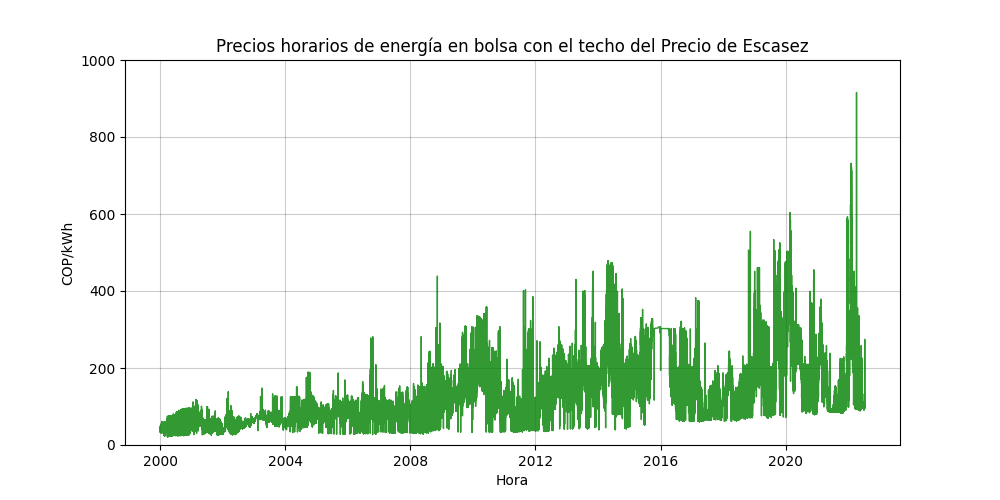

In [45]:
#*******************************************************************************
# 3.6.1.4. Grafica de pbhEsca.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Precios horarios de energía en bolsa con el techo del Precio de Escasez')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Hora')
ax1.plot(pbhEsca.index, pbhEsca.precioConEsca, 'g-', label='Pbh con Escasez', linewidth=1, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 1000)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [24]:
#%run ./py/graficaPbhEsca.py

In [26]:
#*******************************************************************************
# 3.6.1.4. Crea pbmCpe. Precio de bolsa promedio mensual Con Precio de Escasez.
#*******************************************************************************
# pbmCpe = pbhEsca
# pbmCpe = pbmCpe.drop(columns=['precio', 'precEsca'], axis=1)
# pbmCpe = pbmCpe.groupby(pd.to_datetime(pbmCpe.index).to_period('M')).mean()
# pbmCpe.index = pbmCpe.index.to_timestamp()
# pbmCpe

In [27]:
#*******************************************************************************
# 3.6.1.5. Salva  y lee pbmCpe.
#*******************************************************************************
#Salva pbmCpe
# pbmCpe.to_parquet('parquet/pbmCpe.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee pbmCpe
pbmCpe = pd.read_parquet('parquet/pbmCpe.parquet.gzip', engine='fastparquet')

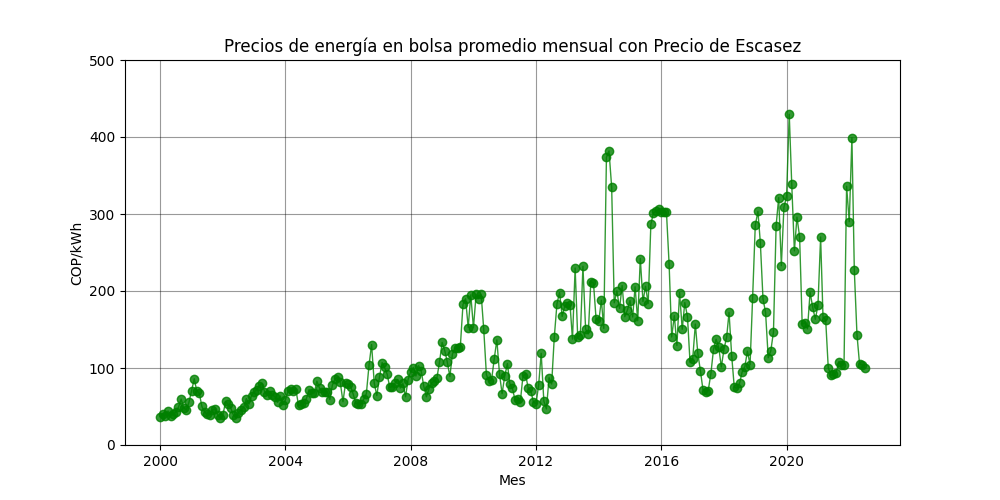

In [43]:
#*******************************************************************************
# 3.6.1.6. Grafica de pbmCpe.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Precios de energía en bolsa promedio mensual con Precio de Escasez')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(pbmCpe.index, pbmCpe.precioConEsca, 'g-o', label='Pbm con Escasez', linewidth=1, alpha=0.8)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 500)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [33]:
#*******************************************************************************
# 3.6.1.7. Crea pbaCpe. Precio de bolsa promedio anual Con Precio de Escasez.
#*******************************************************************************
# pbaCpe = pbmCpe
# pbaCpe = pbmCpe.groupby(pd.to_datetime(pbmCpe.index).to_period('Y')).mean()
# pbaCpe.index = pbaCpe.index.to_timestamp()
# pbaCpe

In [35]:
#*******************************************************************************
# 3.6.1.8. Salva  y lee pbaCpe.
#*******************************************************************************
# Salva pbaCpe
# pbaCpe.to_parquet('parquet/pbaCpe.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
# Lee pbmCpe
# pbaCpe = pd.read_parquet('parquet/pbaCpe.parquet.gzip', engine='fastparquet')

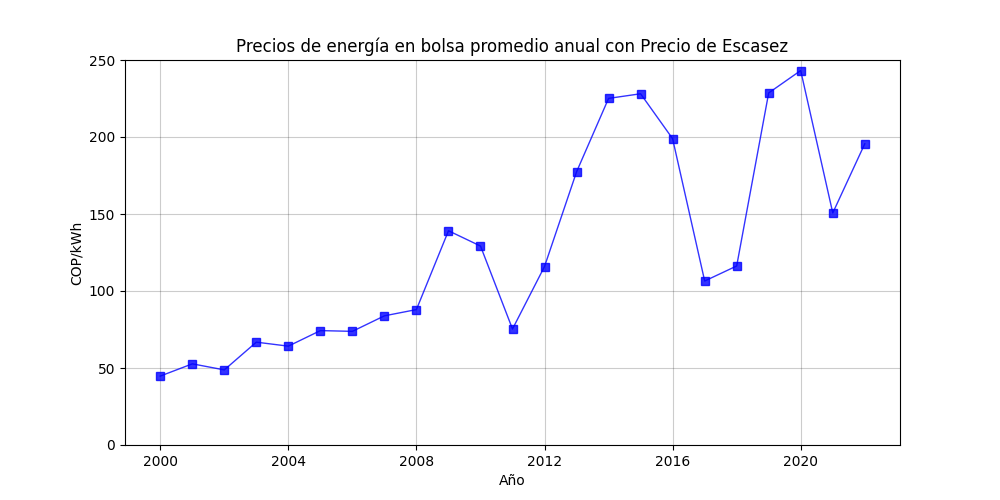

In [41]:
#*******************************************************************************
# 3.6.1.9. Grafica de pbaCpe.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Precios de energía en bolsa promedio anual con Precio de Escasez')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Año')
ax1.plot(pbaCpe.index, pbaCpe.precioConEsca, 'b-s', label='Pba con Escasez', linewidth=1, alpha=0.8)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 250)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

### 3.6.2. Precios de energía en bolsa proyectados.
Para realizar las proyecciones de precio de energía en bolsa promedio mensual (Pbm) para los próximos 78 meses, se tendrá en cuenta lo siguiente:

* Se dejará el Pbm, sin aplicar el techo establecido por el Precio de Escasez.
* Las proyecciones de Pbm se obtendrán aplicando regresiones, tomando diferentes variables exogenas o variables independientes (Xi) como el MEI, el aporte histórico de lluvias, las capacidades de generación, las demandas, etc.
* Para realizar las regresiones no se tendrá como variable endógena o variable dependiente (Y) el Pbm, si no el 'pbm_log'. Esto se hace para garantizar que las predicciones siempre sean positivas, pues los precios de energía en bolsa siempre deben ser positivos. Por otro lado, la variable 'pbm_log' hace que las regresiones sean más robustas porque es menor el rango de los valores de la variable dependiente o variable explicada. Una vez se obtienen las predicciones se debe hacer la conversión de 'pbm_log' a 'pbm' mediante la fórmula pbm = EXP(pbm_log).
* Antes de aplicar la función de logaritmo a los pbm, se le quitará el componente de 'cee'. Este componente no depende de las otras variables exógenas que se utilizarán en la regresión. También se le debe agregar la proyección del cee a los valores de 'pbm' proyectados.      